In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station =Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
for row in session.query(Measurement, Measurement.date).limit(10).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1320>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1390>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1400>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1470>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD14E0>, '2010-01-06')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1550>, '2010-01-07')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD15C0>, '2010-01-08')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1630>, '2010-01-09')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD16A0>, '2010-01-10')
(<sqlalchemy.ext.automap.measurement object at 0x000002648BFD1710>, '2010-01-11')


In [11]:
#total number of dates
date_count = session.query(Measurement).group_by(Measurement.date).count()
print(date_count)

2792


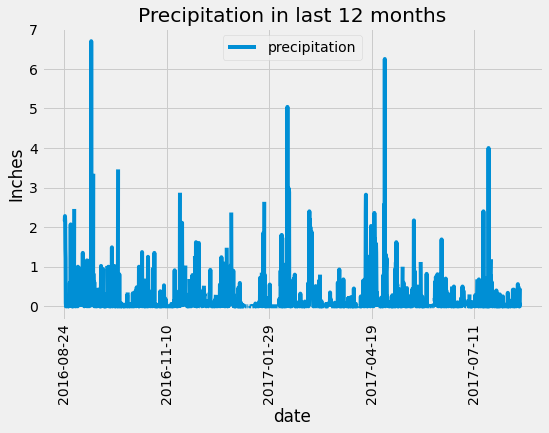

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
start_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
start_date


# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.datetime.strptime(start_date[0], "%Y-%m-%d") - dt.timedelta(days=365)
date_year_ago

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df .plot(title="Precipitation in last 12 months", figsize =(8,5))
plt.legend(loc='upper center')
plt.ylabel("Inches")

plt.xticks(rotation=90)
plt.show()





In [13]:
#check for self
print(start_date)
print(date_year_ago)

('2017-08-23',)
2016-08-23 00:00:00


In [14]:
precipitation_df


,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Available Stations are: {available_stations} ")


Available Stations are: 9 


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, 
                    func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Station List:")
active

Most Active Station List:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
print(f"MOST ACTIVE STATION IS : {active[0][0]}")

MOST ACTIVE STATION IS : USC00519281


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

stat_most_active = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()


print(f"MOST ACTIVE STATION = {stat_most_active[0] [0]}") 
print(f"MIN TEMPERATURE = {stat_most_active[0] [1]}")
print(f"MAX TEMPERATURE = {stat_most_active[0] [2]}")
print(f"AVERAGE TEMPERATURE= {round(stat_most_active[0] [3])}") 

MOST ACTIVE STATION = USC00519281
MIN TEMPERATURE = 54.0
MAX TEMPERATURE = 85.0
AVERAGE TEMPERATURE= 72


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_obs = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == "USC00519281").\
                filter(Measurement.date >= date_year_ago).all()
high_temp_obs

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

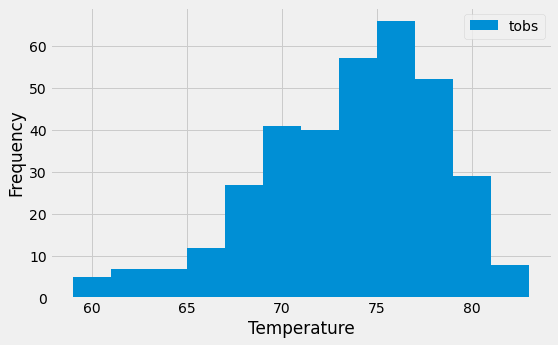

In [21]:
#histogram
high_temp_obs_df = pd.DataFrame(high_temp_obs)
high_temp_obs_df.plot(kind= "hist", bins =12, figsize = (8,5))
plt.xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [ ]:
#----------------------------------------TEMPERATURE ANALYSIS I-------------------------------------------------------------

In [29]:
#query the avg temp in june
june_data = session.query(Measurement.date, func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date) == "06").all()
june_data                      

[('2010-06-01', 74.94411764705882)]

In [30]:
#query the avg temp in dec
dec_data = session.query(Measurement.date, func.avg(Measurement.tobs)).filter(func.strftime("%m",Measurement.date) == "12").all()
dec_data   

[('2010-12-01', 71.04152933421226)]

In [47]:
# put the jun and dec temp data in dataframes
june_all = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == "06").all()
dec_all = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == "12").all()

june_df= pd.DataFrame(june_all, columns=['June', 'Temperature'])
dec_df = pd.DataFrame(dec_all, columns=['December', 'Temperature'])


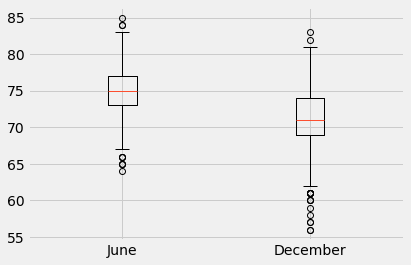

In [49]:
# show the box plot for both
box_data = [june_df["Temperature"], dec_df["Temperature"]]

plt.boxplot(box_data,labels=['June', 'December']);


In [50]:
#running a t-test to determie whether this difference in temperature is meaningful or not- t-test because the valuse are from two  differnet months
stats.ttest_ind(june_df["Temperature"], dec_df["Temperature"])
##Analysis : the p-value is very small and therefore we can accept that the temp diff is significant

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [ ]:
#----------------------------------------TEMPERATURE ANALYSIS II-------------------------------------------------------------

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip = calc_temps('2017-02-28', '2017-03-05')
print(f"tmin, tavg, tmax are : {trip}")

tmin, tavg, tmax are : [(64.0, 72.02777777777777, 78.0)]


In [53]:
#for next one -first I need to import the data in a DF
trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_df

,tmin,tavg,tmax
0,64.0,72.027778,78.0


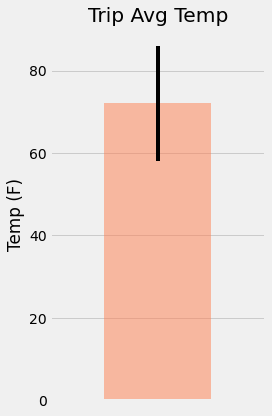

In [54]:

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()

plt.show()


In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
query_all = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
